# Exploratory analysis of the Lichess puzzle database
---

## Overview

This notebook contains some exploratory analysis on the Lichess puzzle database that we collected and processed [here](https://github.com/clarkti5/lichess-puzzle-journey/blob/main/puzzle_journey_data_collection_processing.ipynb).

## Contents

1. [Import the required packages and load the data](#import)
2. [Descriptive analysis](#descriptive-analysis)
3. [Distributions](#distributions)
4. [Exploring `Puzzle_Rating`](#exploring-puzzle-rating)
4. [Exploring `Rating_Deviation`](#exploring-rating-deviation)
5. [Exploring `Popularity`](#exploring-popularity)

# Import the required packages and load the data <a name='import'></a>
---

## Packages

We'll use the following packages.
- [`pandas`](https://pandas.pydata.org/docs/) for analyzing the data.
- [`chess`](https://github.com/niklasf/python-chess) for displaying the puzzles themselves.

In [ ]:
import pandas as pd

!pip install chess
import chess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load the data

Now let's load the `lichess_db_puzzles_clean.csv` from our [data collection and processing efforts](https://github.com/clarkti5/lichess-puzzle-journey/blob/main/puzzle_journey_data_collection_processing.ipynb). Recall, the database is quite large, so this may take a minute to run.

In [ ]:
puzzles_df = pd.read_csv('lichess_db_puzzle_clean.csv')

puzzles_df.head()

,Puzzle_ID,FEN,Moves,Rating,Rating_Deviation,Popularity,Number_of_Plays,Themes,URL,Opening_Tags,Puzzle_Length
0,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - ...,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,1925,74,95,3136,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#48,NaN,5
1,0000D,5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - ...,d3d6 f8d8 d6d8 f6d8,1518,75,96,19577,advantage endgame short,https://lichess.org/F8M8OS71#53,NaN,3
2,0009B,r2qr1k1/b1p2ppp/pp4n1/P1P1p3/4P1n1/B2P2Pb/3NBP...,b6c5 e2g4 h3g4 d1g4,1172,75,86,538,advantage middlegame short,https://lichess.org/4MWQCxQ6/black#32,Kings_Pawn_Game Kings_Pawn_Game_Leonardis_Vari...,3
3,000Vc,8/8/4k1p1/2KpP2p/5PP1/8/8/8 w - - 0 53,g4h5 g6h5 f4f5 e6e5 f5f6 e5f6,1565,81,89,80,crushing endgame long pawnEndgame,https://lichess.org/l6AejDMO#105,NaN,5
4,000Zo,4r3/1k6/pp3r2/1b2P2p/3R1p2/P1R2P2/1P4PP/6K1 w ...,e5f6 e8e1 g1f2 e1f1,1520,75,100,169,endgame mate mateIn2 short,https://lichess.org/n8Ff742v#69,NaN,3


# Descriptive analysis <a name='descriptive-analysis'></a>
---

## Shape of the data

Let's view the dimensions of `puzzles_df`.

In [ ]:
puzzles_df.shape

(3157080, 11)

As we observed already, there are over 3 million puzzles in the database. Note that we have 11 columns in our dataframe—this is 1 more than the [original database](https://database.lichess.org/#puzzles) because we introduced the `Puzzle_Length` column counting the number of moves in the solution of each puzzle.


## Sampling some puzzles

To get an idea of what some of these puzzles look like, we create a random sample of 3 puzzles from the dataframe and display them with `chess`.

In [ ]:
puzzles_df.sample(3)

,Puzzle_ID,FEN,Moves,Rating,Rating_Deviation,Popularity,Number_of_Plays,Themes,URL,Opening_Tags,Puzzle_Length
226167,4R9dk,5r2/p2q3k/1n2b1pp/2r1Qp2/4p3/P2PP3/3NBPPP/2R3K...,e5c5 f8c8 c5c8 b6c8,1533,75,95,17591,advantage middlegame short,https://lichess.org/nEirJadU#65,NaN,3
1511057,TfzFK,8/2r5/4pp2/p1r1p1p1/2P3Rp/1P3P1P/P1KR1kP1/8 b ...,f2e3 g4e4,1303,75,96,4720,endgame master mate mateIn1 oneMove rookEndgame,https://lichess.org/W9PML4W5/black#66,NaN,1
370600,7H10I,5rk1/ppprqp1p/5Np1/4n3/4PRQ1/P1Pp3P/BP1P2P1/6K...,g8h8 g4h4 h7h5 h4g5,1684,333,82,3,crushing middlegame short,https://lichess.org/He7aasnB/black#54,NaN,3


We'll use `chess` to display the board as it would be presented to someone playing each of these puzzles. According to the [documentation](https://database.lichess.org/#puzzles), that means the position resulting from the `FEN` after the first move from `Moves` has been played.

The function below will generate a `.svg` image of a puzzle from it's `Puzzle_ID`.

In [ ]:
def display_puzzle(puzzle_id):
  # Locate the puzzle's FEN.
  FEN = puzzles_df[puzzles_df['Puzzle_ID'] == puzzle_id].iloc[0,1]
  # Identify the moves (i.e. first move followed by the solution) of the puzzle.
  moves = puzzles_df[puzzles_df['Puzzle_ID'] == puzzle_id].iloc[0,2]
  # Extract the first move from the list of moves above.
  first_move = moves.split()[0]

  # Initialize a chess position from the FEN.
  board = chess.Board(FEN)
  # Make the first move to create the position shown to a player.
  board.push(chess.Move.from_uci(first_move))

  return board

Let's take a look at a few puzzles! See if you can solve them—you can check your solution in the `puzzles_df` or seem them in action by navigating to 

>https://lichess.org/training/{puzzle_id}.

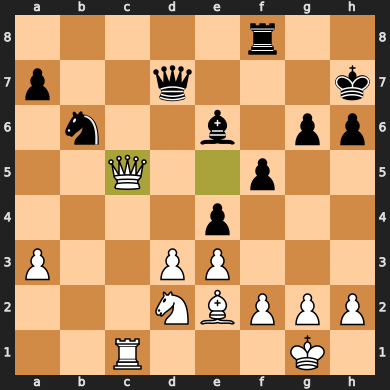

In [ ]:
display_puzzle('4R9dk')

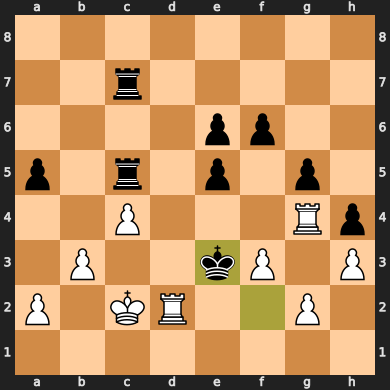

In [ ]:
display_puzzle('TfzFK')

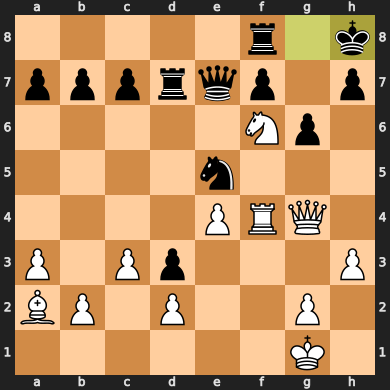

In [ ]:
display_puzzle('7H10I')

## Descriptive statistics

We examine some descriptive statistics of `puzzles_df` below.

In [ ]:
puzzles_df.describe()

,Rating,Rating_Deviation,Popularity,Number_of_Plays,Puzzle_Length
count,3.157080e+06,3.157080e+06,3.157080e+06,3.157080e+06,3.157080e+06
mean,1.549246e+03,9.295655e+01,8.330126e+01,1.318946e+03,3.687106e+00
std,5.152244e+02,5.087326e+01,2.302923e+01,3.749702e+03,1.728832e+00
min,5.450000e+02,5.000000e+01,-1.000000e+02,0.000000e+00,1.000000e+00
25%,1.139000e+03,7.500000e+01,8.100000e+01,6.700000e+01,3.000000e+00
50%,1.514000e+03,7.800000e+01,8.900000e+01,2.490000e+02,3.000000e+00
75%,1.930000e+03,8.900000e+01,9.400000e+01,1.037000e+03,5.000000e+00
max,3.212000e+03,5.000000e+02,1.140000e+02,1.007568e+06,2.900000e+01


Some interesting characteristics include the following.

- The minimum puzzle rating is `545`, while the maximum puzzle rating is `3,212`.
- The median puzzle rating is `1,514`.
- The median puzzle length is `3` moves.
- The maximum puzzle length is `29` moves!
- There are puzzles in the database that have yet to be played.

### Puzzle rating

Below is the puzzle with the minimum puzzle rating (`545`). Can you solve it?

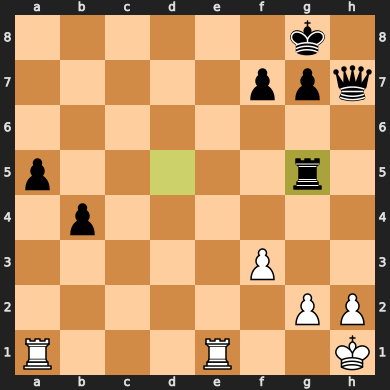

In [ ]:
min_id = puzzles_df[puzzles_df['Rating'] == 545].iloc[0,0]

display_puzzle(min_id)

Now we have the puzzle with maximum puzzle rating (`3,212`). Can you solve it?

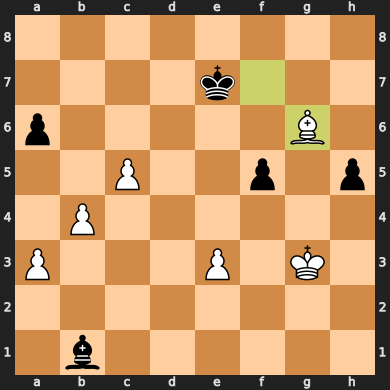

In [ ]:
max_id = puzzles_df[puzzles_df['Rating'] == 3212].iloc[0,0]

display_puzzle(max_id)

### Puzzle length

Below are the longest puzzles in the database. Their solutions consist of `29` moves! Unsurprisingly, they are all rather difficult—each has a rating over `2,300`.

In [ ]:
puzzles_df[puzzles_df['Puzzle_Length'] == 29]

,Puzzle_ID,FEN,Moves,Rating,Rating_Deviation,Popularity,Number_of_Plays,Themes,URL,Opening_Tags,Puzzle_Length
306351,60arM,8/2p5/p7/1p3k2/3K1p2/1P3P2/P7/8 b - - 0 40,f5g5 b3b4 g5f5 d4d5 f5f6 d5e4 f6e6 e4f4 c7c5 b...,2737,104,86,772,advancedPawn crushing endgame pawnEndgame prom...,https://lichess.org/ebKYgXXg/black#80,NaN,29
537656,AY83l,2r2rk1/5pp1/p3pP2/q2pP3/pb1n2PQ/1PNb3P/3B4/2R2...,b4c3 f6g7 d3e4 f1f3 g8g7 d2h6 g7g8 h4g5 e4g6 g...,2385,144,-9,100,advancedPawn advantage middlegame pin veryLong,https://lichess.org/kZQcKfDH/black#50,NaN,29
2101899,fHZfc,8/p7/2r1k2p/1pP1ppp1/1P4P1/P2RKP1P/8/8 w - - 0 39,d3d6 c6d6 g4f5 e6f5 c5d6 f5e6 e3e4 e6d6 e4f5 d...,2634,101,90,113,advancedPawn crushing defensiveMove endgame pr...,https://lichess.org/Vn9IzZOh#77,NaN,29


### Puzzles with no plays

What about the puzzles that have never been played?

In [ ]:
no_plays = puzzles_df[puzzles_df['Number_of_Plays'] == 0]

no_plays.head()

,Puzzle_ID,FEN,Moves,Rating,Rating_Deviation,Popularity,Number_of_Plays,Themes,URL,Opening_Tags,Puzzle_Length
2092,02bLQ,4r3/pp4pp/3B1n2/5k2/2Q3P1/P7/1P1K3P/n3r3 b - -...,f6g4 c4f4 f5g6 f4g4,1582,500,100,0,deflection endgame equality short,https://lichess.org/zxLwsqNJ/black#54,NaN,3
2480,034My,2r2rk1/p2nppbp/3p2p1/q1p4P/4QB2/2P1PN2/PP3PP1/...,g7c3 b2c3 c8b8 c1d2 b8b2 d2e1,1500,500,-100,0,advantage defensiveMove long middlegame,https://lichess.org/zgQYns0V/black#30,Indian_Defense Indian_Defense_Other_variations,5
2586,03CF0,r2qr1k1/p1p1bpBp/2pp1n2/5b2/4P2P/6Q1/PPP2PP1/R...,f5g4 g7f6 e7f6 g3g4,1614,500,100,0,capturingDefender equality kingsideAttack open...,https://lichess.org/dAKdfRR3/black#24,NaN,3
2628,03ET6,5rk1/3b1p1p/1q1pp1pQ/4n2P/p2RP1P1/5P2/BPP5/2K4...,b6d4 h5g6 e5d3 c2d3,1613,500,100,0,equality middlegame short,https://lichess.org/IJ5K8xZ3/black#50,NaN,3
3132,03rlt,8/pp6/2p4N/4k3/PPP3p1/3B1p2/6rP/4K3 b - - 0 39,g2h2 h6g4 e5d4 g4h2,1431,500,100,0,endgame equality fork short,https://lichess.org/gKfrkV8O/black#78,NaN,3


In [ ]:
no_plays.shape

(10367, 11)

There are over `10,000` puzzles that have yet to be played! Let's look at their descriptive statistics.

In [ ]:
no_plays.describe()

,Rating,Rating_Deviation,Popularity,Number_of_Plays,Puzzle_Length
count,10367.000000,10367.0,10367.000000,10367.0,10367.000000
mean,1516.861001,500.0,95.553198,0.0,3.348799
std,75.320516,0.0,29.375457,0.0,1.649687
min,1400.000000,500.0,-100.000000,0.0,1.000000
25%,1444.000000,500.0,100.000000,0.0,3.000000
50%,1505.000000,500.0,100.000000,0.0,3.000000
75%,1584.000000,500.0,100.000000,0.0,3.000000
max,1696.000000,500.0,100.000000,0.0,17.000000


- It appears that puzzles are generally initiated with a rating between `1400` and `1700`. 
- The rating deviation is set at `500` to start. 
- There is at least one puzzle with a popularity set to `-100`.

In regard to the last point, I'm interested in the puzzle that has started its life with minimum popularity.

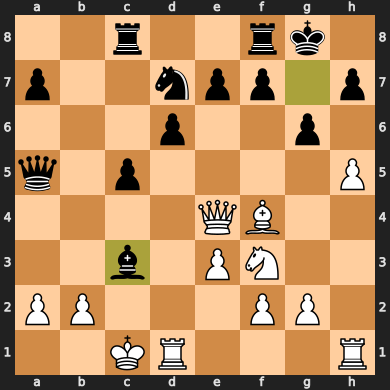

In [ ]:
min_pop_id = no_plays[no_plays['Popularity'] == -100].iloc[0,0]

display_puzzle(min_pop_id)

I'm not sure why this puzzle was chosen to be so unpopular.

## Correlations

How are the features of `puzzles_df` related to one another?

In [ ]:
puzzles_df.corr(numeric_only = True)

,Rating,Rating_Deviation,Popularity,Number_of_Plays,Puzzle_Length
Rating,1.000000,-0.016133,0.005344,0.013692,0.483482
Rating_Deviation,-0.016133,1.000000,-0.338796,-0.112356,-0.054405
Popularity,0.005344,-0.338796,1.000000,0.154414,0.050648
Number_of_Plays,0.013692,-0.112356,0.154414,1.000000,0.035646
Puzzle_Length,0.483482,-0.054405,0.050648,0.035646,1.000000


- Perhaps unsurprisingly, `Puzzle_Length` and `Rating` are moderately positively correlated (i.e. longer puzzles tend to be more difficult).
- There is a weak negative correlation between `Popularity` and `Rating_Deviation`. This may indicate that popular puzzles tend to have lower rating deviation.
  - If `Rating_Deviation` essentially measures the predictability of a puzzle's difficulty and `Popularity` essentially measures whether a puzzle meets the users' expectations, it would make sense that predictably-performing puzzles (more popular puzzles) have less uncertaintiy in their level of difficulty.